In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kerastuner as kt
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score ,recall_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from numpy import average
from keras import backend as K

In [10]:

df= pd.read_csv("Full_LSTM_Classification.csv")
DX=pd.read_csv("DX_Four_Classes.csv")
df=df.sort_values(by='RID', ascending=True)
DX=DX.sort_values(by='RID', ascending=True)
groupby=df.groupby("RID").count()
len(groupby)



1371

In [11]:
test= pd.read_csv("DX_test_four_classes.csv")
df1=pd.merge(df, test, on='RID', how='inner')
for j in range(0,len(test)):
    df=df[df.RID!=test['RID'][j]]

In [12]:
y_test = pd.merge(DX, test, on='RID', how='inner')                        
for j in range(0,len(test)):
    DX=DX[DX.RID!=test['RID'][j]]

In [13]:
df=df.sort_values(by='RID', ascending=True)
X_train1=df.drop(['RID','VISCODE2'],axis = 1 )


In [14]:
df1=df1.sort_values(by='RID', ascending=True)
X_test1=df1.drop(['RID','VISCODE2'],axis = 1 )

In [15]:
num_features=len(X_train1.columns)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train1)
scaler1 = MinMaxScaler(feature_range=(0, 1))
X_test = scaler1.fit_transform(X_test1)


In [16]:
X_train= X_train.reshape(len(DX), 4, num_features)
DX=DX.sort_values(by='RID', ascending=True)
train_label=DX.drop(['RID'],axis = 1 )
X_test= X_test.reshape(len(y_test), 4, num_features)
test_label1=y_test.sort_values(by='RID', ascending=True)
test_label=test_label1.drop(['RID'],axis = 1 )


In [17]:
encoder = LabelEncoder()
encoder.fit(train_label)
encoded_Y= encoder.transform(train_label)
y_train = np_utils.to_categorical(encoded_Y)
encoder1 = LabelEncoder()
encoder1.fit(test_label)
y_test = encoder.transform(test_label)

C:\Users\hager\anaconda3\envs\hager\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
def build_model(hp):
    num_units_min  =  50
    num_units_max  =  500
    num_units_step =  20

    dropout_min  =  .2
    dropout_max  =  0.5
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 input_shape=(X_train.shape[1], X_train.shape[2]), 
                                                 activation='relu',  kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1',values=[0.01, 0.05, 0.1,.2,.3,.4,.5])),                  
                                                 return_sequences = True))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
 
    for i in range(hp.Int('num_layers', 1, 1)):
        model.add(layers.LSTM(units=hp.Int('unitfor_'+ str(i),
                                           min_value=num_units_min,
                                           max_value=num_units_max,
                                         step=num_units_step),
                                        activation='relu',  kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate2',values=[0.01, 0.05, 0.1, .2,.3,.4,.5])),                  
                                          return_sequences = True))
        model.add(layers.Dropout(hp.Float('dropoutfor_'+ str(i), 
                                    min_value=dropout_min,
                                    max_value=dropout_max,
                                      step=dropout_step)))
    model.add(layers.LSTM(units=hp.Int('unit4',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                 activation='relu',  kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate3',values=[0.01, 0.05, 0.1,.2,.3,.4,.5])),                  
                                                 return_sequences = False))
    model.add(layers.Dropout(hp.Float('dropout_4',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) ) 
    
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[ 1e-4])),
       loss='categorical_crossentropy', 
       metrics=['acc',f1_m,precision_m, recall_m])
    return model


In [20]:
X_t, X_val, y_t, y_val = train_test_split(
     X_train, y_train, test_size=0.10, stratify= y_train, shuffle=True, random_state=None) 
len(X_t)

1109

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials=2,
    project_name='lstm1Warpper')



In [22]:

early_stopping = EarlyStopping(monitor='val_acc', patience=30, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

h=tuner.search(X_t, y_t,
             epochs=100,
             batch_size=50, 
             callbacks=callback_list, validation_data=(X_val,y_val) )
            
model = tuner.get_best_models(num_models=1)[0]


Trial 2 Complete [00h 02m 23s]
val_acc: 0.8548387289047241

Best val_acc So Far: 0.8790322542190552
Total elapsed time: 00h 05m 36s
INFO:tensorflow:Oracle triggered exit


In [23]:


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 350)            676200    
_________________________________________________________________
dropout (Dropout)            (None, 4, 350)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 210)            471240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 210)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                78680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2

In [24]:
tuner.get_best_hyperparameters()[0].values

{'unit1': 350,
 'reg_rate1': 0.3,
 'dropout_1': 0.30000000000000004,
 'num_layers': 1,
 'unitfor_0': 210,
 'reg_rate2': 0.05,
 'dropoutfor_0': 0.30000000000000004,
 'unit4': 70,
 'reg_rate3': 0.01,
 'dropout_4': 0.5000000000000001,
 'learning_rate': 0.0001}

In [25]:
#model.reset_states()
history= model.fit(X_t, y_t, epochs=70, batch_size=50,  verbose=1,shuffle=True, validation_data=(X_val,y_val))


Epoch 1/70
23/23 [==============================] - 11s 121ms/step - loss: 0.7597 - acc: 0.8011 - f1_m: 0.8013 - precision_m: 0.8451 - recall_m: 0.7627 - val_loss: 0.6429 - val_acc: 0.8548 - val_f1_m: 0.8587 - val_precision_m: 0.8973 - val_recall_m: 0.8239
Epoch 2/70
23/23 [==============================] - 1s 62ms/step - loss: 0.7155 - acc: 0.8193 - f1_m: 0.8195 - precision_m: 0.8604 - recall_m: 0.7837 - val_loss: 0.5997 - val_acc: 0.8629 - val_f1_m: 0.8616 - val_precision_m: 0.8802 - val_recall_m: 0.8439
Epoch 3/70
23/23 [==============================] - 2s 68ms/step - loss: 0.7703 - acc: 0.8129 - f1_m: 0.8056 - precision_m: 0.8472 - recall_m: 0.7683 - val_loss: 0.5821 - val_acc: 0.8629 - val_f1_m: 0.8502 - val_precision_m: 0.8786 - val_recall_m: 0.8239
Epoch 4/70
23/23 [==============================] - 1s 65ms/step - loss: 0.7302 - acc: 0.8053 - f1_m: 0.8008 - precision_m: 0.8465 - recall_m: 0.7608 - val_loss: 0.5978 - val_acc: 0.8548 - val_f1_m: 0.8468 - val_precision_m: 0.8716 -

23/23 [==============================] - 2s 70ms/step - loss: 0.6700 - acc: 0.8052 - f1_m: 0.8087 - precision_m: 0.8678 - recall_m: 0.7584 - val_loss: 0.5936 - val_acc: 0.8387 - val_f1_m: 0.8323 - val_precision_m: 0.8561 - val_recall_m: 0.8100
Epoch 34/70
23/23 [==============================] - 2s 81ms/step - loss: 0.6514 - acc: 0.8176 - f1_m: 0.8191 - precision_m: 0.8705 - recall_m: 0.7740 - val_loss: 0.5406 - val_acc: 0.8710 - val_f1_m: 0.8608 - val_precision_m: 0.8864 - val_recall_m: 0.8372
Epoch 35/70
23/23 [==============================] - 2s 89ms/step - loss: 0.6731 - acc: 0.8077 - f1_m: 0.8098 - precision_m: 0.8607 - recall_m: 0.7657 - val_loss: 0.6162 - val_acc: 0.7984 - val_f1_m: 0.8078 - val_precision_m: 0.8342 - val_recall_m: 0.7833
Epoch 36/70
23/23 [==============================] - 2s 84ms/step - loss: 0.7210 - acc: 0.7827 - f1_m: 0.7783 - precision_m: 0.8277 - recall_m: 0.7353 - val_loss: 0.5464 - val_acc: 0.8468 - val_f1_m: 0.8366 - val_precision_m: 0.8576 - val_recal

23/23 [==============================] - 2s 70ms/step - loss: 0.6835 - acc: 0.7827 - f1_m: 0.7848 - precision_m: 0.8361 - recall_m: 0.7401 - val_loss: 0.5210 - val_acc: 0.8629 - val_f1_m: 0.8567 - val_precision_m: 0.8847 - val_recall_m: 0.8306
Epoch 66/70
23/23 [==============================] - 2s 72ms/step - loss: 0.6256 - acc: 0.8006 - f1_m: 0.8040 - precision_m: 0.8435 - recall_m: 0.7685 - val_loss: 0.5261 - val_acc: 0.8710 - val_f1_m: 0.8568 - val_precision_m: 0.8852 - val_recall_m: 0.8306
Epoch 67/70
23/23 [==============================] - 2s 105ms/step - loss: 0.6506 - acc: 0.7874 - f1_m: 0.7945 - precision_m: 0.8577 - recall_m: 0.7411 - val_loss: 0.5696 - val_acc: 0.8468 - val_f1_m: 0.8353 - val_precision_m: 0.8624 - val_recall_m: 0.8100
Epoch 68/70
23/23 [==============================] - 2s 80ms/step - loss: 0.6071 - acc: 0.8323 - f1_m: 0.8267 - precision_m: 0.8699 - recall_m: 0.7881 - val_loss: 0.7030 - val_acc: 0.7984 - val_f1_m: 0.7819 - val_precision_m: 0.7954 - val_reca

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


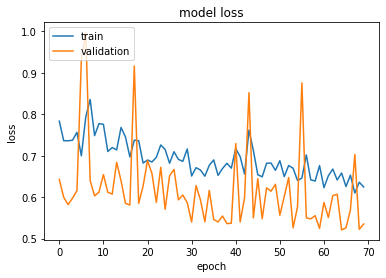

In [26]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
my_dict_Train={"Accuracy_Train": [],"Precision_Train": [],"Recall_Train": [], "F1_score_Train":[]};
my_dict_STD={"Accuracy_Train": [],"Precision_Train": [],"Recall_Train": [], "F1_score_Train":[]};
my_dict_Test={"Accuracy_Test": [],"Precision_Test": [],"Recall_Test": [], "F1_score_Test":[]};

In [28]:
for i in range(0,10):
        from sklearn.model_selection import StratifiedKFold
        if i==0:
            r=70
        elif i== 1:
            r=80
        elif i== 2:
            r=90
        elif i== 3:
            r=100
        elif i== 4:
            r=130
        elif i==6:
            r=120
        elif i==7:
            r=50
        elif i==8:
            r=60
        elif i==9:
            r=30
        elif i==5:
            r=10
        
        X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.10, stratify= y_train, shuffle=True, random_state=r)
        h=model.fit(X_t, y_t, epochs=50, batch_size=50,  verbose=1,shuffle=True, validation_data=(X_val,y_val))

        my_dict_Train["Accuracy_Train"].append(round(100*np.mean(h.history['val_acc']),2))
        my_dict_STD["Accuracy_Train"].append(round(100*np.std(h.history['val_acc']), 2))
        my_dict_Train["Precision_Train"].append(round(100*np.mean(h.history['val_precision_m']),2))
        my_dict_STD["Precision_Train"].append(round(100*np.std(h.history['val_precision_m']), 2))
        my_dict_Train["Recall_Train"].append(round(100*np.mean(h.history['val_recall_m']),2))
        my_dict_STD["Recall_Train"].append(round(100*np.std(h.history['val_recall_m']), 2))
        my_dict_Train["F1_score_Train"].append(round(100*np.mean(h.history['val_f1_m']),2))
        my_dict_STD["F1_score_Train"].append(round(100*np.std(h.history['val_f1_m']), 2))
        y_p = model.predict(X_test)
        y_pred= np.argmax(y_p, axis=1)
        my_dict_Test["Accuracy_Test"].append(round(100*accuracy_score(y_test,y_pred), 2))
        my_dict_Test["Precision_Test"].append(round(100*precision_score(y_test, y_pred, average='weighted'), 2))
        my_dict_Test["Recall_Test"].append(round(100*recall_score(y_test, y_pred, average='weighted'), 2))
        my_dict_Test["F1_score_Test"].append(round(100*f1_score(y_test, y_pred, average='weighted') , 2))

Epoch 1/50
23/23 [==============================] - 1s 65ms/step - loss: 0.6201 - acc: 0.8323 - f1_m: 0.8291 - precision_m: 0.8749 - recall_m: 0.7891 - val_loss: 0.4504 - val_acc: 0.8710 - val_f1_m: 0.8859 - val_precision_m: 0.9078 - val_recall_m: 0.8656
Epoch 2/50
23/23 [==============================] - 1s 65ms/step - loss: 0.6419 - acc: 0.8188 - f1_m: 0.8169 - precision_m: 0.8562 - recall_m: 0.7820 - val_loss: 0.4748 - val_acc: 0.8710 - val_f1_m: 0.8733 - val_precision_m: 0.9118 - val_recall_m: 0.8383
Epoch 3/50
23/23 [==============================] - 1s 61ms/step - loss: 0.6291 - acc: 0.8133 - f1_m: 0.8194 - precision_m: 0.8645 - recall_m: 0.7800 - val_loss: 0.4533 - val_acc: 0.8952 - val_f1_m: 0.8794 - val_precision_m: 0.9256 - val_recall_m: 0.8383
Epoch 4/50
23/23 [==============================] - 1s 65ms/step - loss: 0.6656 - acc: 0.8052 - f1_m: 0.8023 - precision_m: 0.8558 - recall_m: 0.7572 - val_loss: 0.5032 - val_acc: 0.8710 - val_f1_m: 0.8725 - val_precision_m: 0.9533 - v

Epoch 33/50
23/23 [==============================] - 1s 65ms/step - loss: 0.5930 - acc: 0.8278 - f1_m: 0.8360 - precision_m: 0.8721 - recall_m: 0.8035 - val_loss: 0.4827 - val_acc: 0.8710 - val_f1_m: 0.8825 - val_precision_m: 0.9326 - val_recall_m: 0.8383
Epoch 34/50
23/23 [==============================] - 1s 57ms/step - loss: 0.6057 - acc: 0.8197 - f1_m: 0.8200 - precision_m: 0.8666 - recall_m: 0.7791 - val_loss: 0.4663 - val_acc: 0.8710 - val_f1_m: 0.8741 - val_precision_m: 0.8829 - val_recall_m: 0.8656
Epoch 35/50
23/23 [==============================] - 1s 54ms/step - loss: 0.5827 - acc: 0.8242 - f1_m: 0.8196 - precision_m: 0.8509 - recall_m: 0.7907 - val_loss: 0.4646 - val_acc: 0.8629 - val_f1_m: 0.8740 - val_precision_m: 0.9056 - val_recall_m: 0.8456
Epoch 36/50
23/23 [==============================] - 1s 53ms/step - loss: 0.5992 - acc: 0.8142 - f1_m: 0.8174 - precision_m: 0.8585 - recall_m: 0.7813 - val_loss: 0.4619 - val_acc: 0.8387 - val_f1_m: 0.8799 - val_precision_m: 0.9190

23/23 [==============================] - 2s 73ms/step - loss: 0.5876 - acc: 0.8287 - f1_m: 0.8314 - precision_m: 0.8718 - recall_m: 0.7952 - val_loss: 0.5367 - val_acc: 0.8548 - val_f1_m: 0.8326 - val_precision_m: 0.8795 - val_recall_m: 0.7906
Epoch 15/50
23/23 [==============================] - 2s 71ms/step - loss: 0.5599 - acc: 0.8386 - f1_m: 0.8336 - precision_m: 0.8713 - recall_m: 0.8003 - val_loss: 0.5370 - val_acc: 0.8468 - val_f1_m: 0.8197 - val_precision_m: 0.8591 - val_recall_m: 0.7839
Epoch 16/50
23/23 [==============================] - 2s 66ms/step - loss: 0.6098 - acc: 0.8133 - f1_m: 0.8026 - precision_m: 0.8525 - recall_m: 0.7594 - val_loss: 0.5243 - val_acc: 0.8468 - val_f1_m: 0.8484 - val_precision_m: 0.8823 - val_recall_m: 0.8172
Epoch 17/50
23/23 [==============================] - 2s 67ms/step - loss: 0.5859 - acc: 0.8179 - f1_m: 0.8195 - precision_m: 0.8729 - recall_m: 0.7733 - val_loss: 0.5098 - val_acc: 0.8468 - val_f1_m: 0.8466 - val_precision_m: 0.8709 - val_recal

23/23 [==============================] - 1s 62ms/step - loss: 0.5629 - acc: 0.8242 - f1_m: 0.8225 - precision_m: 0.8601 - recall_m: 0.7886 - val_loss: 0.5977 - val_acc: 0.8306 - val_f1_m: 0.8055 - val_precision_m: 0.8285 - val_recall_m: 0.7839
Epoch 47/50
23/23 [==============================] - 1s 60ms/step - loss: 0.5435 - acc: 0.8395 - f1_m: 0.8194 - precision_m: 0.8648 - recall_m: 0.7794 - val_loss: 0.5094 - val_acc: 0.8548 - val_f1_m: 0.8487 - val_precision_m: 0.8827 - val_recall_m: 0.8172
Epoch 48/50
23/23 [==============================] - 1s 65ms/step - loss: 0.5438 - acc: 0.8323 - f1_m: 0.8288 - precision_m: 0.8739 - recall_m: 0.7890 - val_loss: 0.5782 - val_acc: 0.8065 - val_f1_m: 0.8127 - val_precision_m: 0.8516 - val_recall_m: 0.7772
Epoch 49/50
23/23 [==============================] - 1s 62ms/step - loss: 0.5505 - acc: 0.8269 - f1_m: 0.8185 - precision_m: 0.8638 - recall_m: 0.7811 - val_loss: 0.5174 - val_acc: 0.8548 - val_f1_m: 0.8351 - val_precision_m: 0.8688 - val_recal

23/23 [==============================] - 1s 57ms/step - loss: 0.5886 - acc: 0.8079 - f1_m: 0.8006 - precision_m: 0.8461 - recall_m: 0.7612 - val_loss: 0.5774 - val_acc: 0.8306 - val_f1_m: 0.8131 - val_precision_m: 0.8533 - val_recall_m: 0.7772
Epoch 29/50
23/23 [==============================] - 1s 55ms/step - loss: 0.5505 - acc: 0.8314 - f1_m: 0.8275 - precision_m: 0.8736 - recall_m: 0.7873 - val_loss: 0.5229 - val_acc: 0.8387 - val_f1_m: 0.8368 - val_precision_m: 0.8808 - val_recall_m: 0.7972
Epoch 30/50
23/23 [==============================] - 1s 57ms/step - loss: 0.5364 - acc: 0.8440 - f1_m: 0.8463 - precision_m: 0.8827 - recall_m: 0.8134 - val_loss: 0.5265 - val_acc: 0.8548 - val_f1_m: 0.8340 - val_precision_m: 0.8744 - val_recall_m: 0.7972
Epoch 31/50
23/23 [==============================] - 1s 57ms/step - loss: 0.5569 - acc: 0.8296 - f1_m: 0.8250 - precision_m: 0.8585 - recall_m: 0.7947 - val_loss: 0.6283 - val_acc: 0.8065 - val_f1_m: 0.8123 - val_precision_m: 0.8524 - val_recal

23/23 [==============================] - 1s 61ms/step - loss: 0.5370 - acc: 0.8314 - f1_m: 0.8392 - precision_m: 0.8776 - recall_m: 0.8047 - val_loss: 0.5410 - val_acc: 0.8629 - val_f1_m: 0.8610 - val_precision_m: 0.9104 - val_recall_m: 0.81830.8324 - f1_m: 0.8387 - precision_m: 0.8786 - recall_m: 0.802
Epoch 10/50
23/23 [==============================] - 1s 63ms/step - loss: 0.5383 - acc: 0.8332 - f1_m: 0.8318 - precision_m: 0.8646 - recall_m: 0.8021 - val_loss: 0.5433 - val_acc: 0.8548 - val_f1_m: 0.8632 - val_precision_m: 0.9159 - val_recall_m: 0.8183
Epoch 11/50
23/23 [==============================] - 1s 61ms/step - loss: 0.5271 - acc: 0.8386 - f1_m: 0.8427 - precision_m: 0.8854 - recall_m: 0.8047 - val_loss: 0.6711 - val_acc: 0.7742 - val_f1_m: 0.7714 - val_precision_m: 0.8354 - val_recall_m: 0.7167
Epoch 12/50
23/23 [==============================] - 1s 62ms/step - loss: 0.5690 - acc: 0.8251 - f1_m: 0.8239 - precision_m: 0.8643 - recall_m: 0.7877 - val_loss: 0.5501 - val_acc: 0.

Epoch 41/50
23/23 [==============================] - 1s 56ms/step - loss: 0.5255 - acc: 0.8314 - f1_m: 0.8320 - precision_m: 0.8781 - recall_m: 0.7917 - val_loss: 0.6728 - val_acc: 0.7742 - val_f1_m: 0.7914 - val_precision_m: 0.8452 - val_recall_m: 0.7444
Epoch 42/50
23/23 [==============================] - 1s 55ms/step - loss: 0.5912 - acc: 0.8079 - f1_m: 0.8058 - precision_m: 0.8502 - recall_m: 0.7665 - val_loss: 0.5754 - val_acc: 0.8387 - val_f1_m: 0.8314 - val_precision_m: 0.8856 - val_recall_m: 0.7844
Epoch 43/50
23/23 [==============================] - 1s 56ms/step - loss: 0.5547 - acc: 0.8142 - f1_m: 0.8165 - precision_m: 0.8583 - recall_m: 0.7790 - val_loss: 0.5646 - val_acc: 0.8306 - val_f1_m: 0.8314 - val_precision_m: 0.8856 - val_recall_m: 0.7844
Epoch 44/50
23/23 [==============================] - 1s 59ms/step - loss: 0.5393 - acc: 0.8314 - f1_m: 0.8309 - precision_m: 0.8757 - recall_m: 0.7917 - val_loss: 0.5983 - val_acc: 0.8306 - val_f1_m: 0.8244 - val_precision_m: 0.8783

23/23 [==============================] - 2s 87ms/step - loss: 0.5348 - acc: 0.8332 - f1_m: 0.8127 - precision_m: 0.8517 - recall_m: 0.7777 - val_loss: 0.6249 - val_acc: 0.7984 - val_f1_m: 0.8067 - val_precision_m: 0.8555 - val_recall_m: 0.7633
Epoch 23/50
23/23 [==============================] - 2s 77ms/step - loss: 0.5018 - acc: 0.8440 - f1_m: 0.8456 - precision_m: 0.8909 - recall_m: 0.8056 - val_loss: 0.7559 - val_acc: 0.8065 - val_f1_m: 0.7986 - val_precision_m: 0.8213 - val_recall_m: 0.7778
Epoch 24/50
23/23 [==============================] - 2s 67ms/step - loss: 0.7134 - acc: 0.7638 - f1_m: 0.7542 - precision_m: 0.8204 - recall_m: 0.6998 - val_loss: 0.6364 - val_acc: 0.8226 - val_f1_m: 0.8081 - val_precision_m: 0.8504 - val_recall_m: 0.7706
Epoch 25/50
23/23 [==============================] - 2s 66ms/step - loss: 0.5430 - acc: 0.8305 - f1_m: 0.8311 - precision_m: 0.8723 - recall_m: 0.7947 - val_loss: 0.6572 - val_acc: 0.7984 - val_f1_m: 0.8139 - val_precision_m: 0.8465 - val_recal

23/23 [==============================] - 1s 62ms/step - loss: 0.5489 - acc: 0.8359 - f1_m: 0.8221 - precision_m: 0.8574 - recall_m: 0.7902 - val_loss: 0.5695 - val_acc: 0.8145 - val_f1_m: 0.8214 - val_precision_m: 0.8479 - val_recall_m: 0.7967
Epoch 5/50
23/23 [==============================] - 2s 66ms/step - loss: 0.5810 - acc: 0.8106 - f1_m: 0.7985 - precision_m: 0.8479 - recall_m: 0.7555 - val_loss: 0.6022 - val_acc: 0.7984 - val_f1_m: 0.8051 - val_precision_m: 0.8282 - val_recall_m: 0.7833
Epoch 6/50
23/23 [==============================] - 1s 65ms/step - loss: 0.5167 - acc: 0.8332 - f1_m: 0.8397 - precision_m: 0.8833 - recall_m: 0.8009 - val_loss: 0.5843 - val_acc: 0.7984 - val_f1_m: 0.7897 - val_precision_m: 0.8517 - val_recall_m: 0.7367
Epoch 7/50
23/23 [==============================] - 2s 67ms/step - loss: 0.4949 - acc: 0.8440 - f1_m: 0.8452 - precision_m: 0.8772 - recall_m: 0.8160 - val_loss: 0.6639 - val_acc: 0.7823 - val_f1_m: 0.7870 - val_precision_m: 0.8636 - val_recall_m

23/23 [==============================] - 1s 65ms/step - loss: 0.5067 - acc: 0.8368 - f1_m: 0.8270 - precision_m: 0.8719 - recall_m: 0.7872 - val_loss: 0.6483 - val_acc: 0.7419 - val_f1_m: 0.7704 - val_precision_m: 0.8535 - val_recall_m: 0.7028
Epoch 37/50
23/23 [==============================] - 2s 71ms/step - loss: 0.4840 - acc: 0.8431 - f1_m: 0.8478 - precision_m: 0.8889 - recall_m: 0.8108 - val_loss: 0.8151 - val_acc: 0.7258 - val_f1_m: 0.7140 - val_precision_m: 0.7427 - val_recall_m: 0.6878
Epoch 38/50
23/23 [==============================] - 1s 64ms/step - loss: 0.5153 - acc: 0.8332 - f1_m: 0.8269 - precision_m: 0.8688 - recall_m: 0.7895 - val_loss: 0.7432 - val_acc: 0.7661 - val_f1_m: 0.7718 - val_precision_m: 0.8470 - val_recall_m: 0.7094
Epoch 39/50
23/23 [==============================] - 1s 64ms/step - loss: 0.5302 - acc: 0.8179 - f1_m: 0.8211 - precision_m: 0.8700 - recall_m: 0.7782 - val_loss: 0.6230 - val_acc: 0.8065 - val_f1_m: 0.7914 - val_precision_m: 0.8141 - val_recal

23/23 [==============================] - 1s 61ms/step - loss: 0.4881 - acc: 0.8485 - f1_m: 0.8384 - precision_m: 0.8855 - recall_m: 0.7968 - val_loss: 0.5036 - val_acc: 0.8387 - val_f1_m: 0.8453 - val_precision_m: 0.8827 - val_recall_m: 0.8111
Epoch 19/50
23/23 [==============================] - 1s 59ms/step - loss: 0.5034 - acc: 0.8377 - f1_m: 0.8340 - precision_m: 0.8733 - recall_m: 0.7990 - val_loss: 0.4602 - val_acc: 0.8306 - val_f1_m: 0.8449 - val_precision_m: 0.8899 - val_recall_m: 0.8044
Epoch 20/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4999 - acc: 0.8458 - f1_m: 0.8420 - precision_m: 0.8878 - recall_m: 0.8021 - val_loss: 0.5340 - val_acc: 0.8306 - val_f1_m: 0.8269 - val_precision_m: 0.8743 - val_recall_m: 0.7844
Epoch 21/50
23/23 [==============================] - 1s 65ms/step - loss: 0.5159 - acc: 0.8224 - f1_m: 0.8201 - precision_m: 0.8680 - recall_m: 0.7777 - val_loss: 0.5927 - val_acc: 0.7903 - val_f1_m: 0.8163 - val_precision_m: 0.8767 - val_recal

23/23 [==============================] - 1s 53ms/step - loss: 0.6024 - acc: 0.7881 - f1_m: 0.7864 - precision_m: 0.8336 - recall_m: 0.7446 - val_loss: 0.5235 - val_acc: 0.8145 - val_f1_m: 0.8271 - val_precision_m: 0.8931 - val_recall_m: 0.7706
Epoch 1/50
23/23 [==============================] - 1s 60ms/step - loss: 0.5119 - acc: 0.8305 - f1_m: 0.8298 - precision_m: 0.8726 - recall_m: 0.7916 - val_loss: 0.4158 - val_acc: 0.8710 - val_f1_m: 0.8317 - val_precision_m: 0.8977 - val_recall_m: 0.7761
Epoch 2/50
23/23 [==============================] - 1s 57ms/step - loss: 0.4658 - acc: 0.8476 - f1_m: 0.8496 - precision_m: 0.8950 - recall_m: 0.8095 - val_loss: 0.4265 - val_acc: 0.8790 - val_f1_m: 0.8460 - val_precision_m: 0.9131 - val_recall_m: 0.7894
Epoch 3/50
23/23 [==============================] - 1s 55ms/step - loss: 0.5014 - acc: 0.8386 - f1_m: 0.8407 - precision_m: 0.8807 - recall_m: 0.8051 - val_loss: 0.4347 - val_acc: 0.8548 - val_f1_m: 0.8422 - val_precision_m: 0.9208 - val_recall_m

23/23 [==============================] - 2s 69ms/step - loss: 0.5059 - acc: 0.8341 - f1_m: 0.8295 - precision_m: 0.8694 - recall_m: 0.7938 - val_loss: 0.4706 - val_acc: 0.8629 - val_f1_m: 0.8246 - val_precision_m: 0.8901 - val_recall_m: 0.7694
Epoch 33/50
23/23 [==============================] - 2s 67ms/step - loss: 0.5009 - acc: 0.8359 - f1_m: 0.8310 - precision_m: 0.8693 - recall_m: 0.7969 - val_loss: 0.5127 - val_acc: 0.8145 - val_f1_m: 0.8067 - val_precision_m: 0.8737 - val_recall_m: 0.7494
Epoch 34/50
23/23 [==============================] - 2s 67ms/step - loss: 0.5007 - acc: 0.8269 - f1_m: 0.8316 - precision_m: 0.8734 - recall_m: 0.7947 - val_loss: 0.4533 - val_acc: 0.8710 - val_f1_m: 0.8359 - val_precision_m: 0.8987 - val_recall_m: 0.7828
Epoch 35/50
23/23 [==============================] - 2s 66ms/step - loss: 0.5794 - acc: 0.7980 - f1_m: 0.7951 - precision_m: 0.8340 - recall_m: 0.7608 - val_loss: 0.6425 - val_acc: 0.7661 - val_f1_m: 0.7586 - val_precision_m: 0.8248 - val_recal

23/23 [==============================] - 1s 64ms/step - loss: 0.5137 - acc: 0.8296 - f1_m: 0.8327 - precision_m: 0.8843 - recall_m: 0.7873 - val_loss: 0.4787 - val_acc: 0.8629 - val_f1_m: 0.8304 - val_precision_m: 0.8843 - val_recall_m: 0.7828
Epoch 15/50
23/23 [==============================] - 1s 58ms/step - loss: 0.4572 - acc: 0.8602 - f1_m: 0.8555 - precision_m: 0.8933 - recall_m: 0.8213 - val_loss: 0.4716 - val_acc: 0.8306 - val_f1_m: 0.8297 - val_precision_m: 0.8663 - val_recall_m: 0.7961
Epoch 16/50
23/23 [==============================] - 1s 59ms/step - loss: 0.4607 - acc: 0.8503 - f1_m: 0.8497 - precision_m: 0.8862 - recall_m: 0.8169 - val_loss: 0.4740 - val_acc: 0.8226 - val_f1_m: 0.8268 - val_precision_m: 0.8600 - val_recall_m: 0.7961
Epoch 17/50
23/23 [==============================] - 1s 59ms/step - loss: 0.4616 - acc: 0.8368 - f1_m: 0.8375 - precision_m: 0.8767 - recall_m: 0.8024 - val_loss: 0.4681 - val_acc: 0.8548 - val_f1_m: 0.8250 - val_precision_m: 0.8725 - val_recal

23/23 [==============================] - 2s 85ms/step - loss: 0.4846 - acc: 0.8368 - f1_m: 0.8274 - precision_m: 0.8622 - recall_m: 0.7959 - val_loss: 0.4938 - val_acc: 0.8468 - val_f1_m: 0.8294 - val_precision_m: 0.8732 - val_recall_m: 0.7900
Epoch 47/50
23/23 [==============================] - 2s 91ms/step - loss: 0.4818 - acc: 0.8368 - f1_m: 0.8425 - precision_m: 0.8934 - recall_m: 0.7978 - val_loss: 0.4710 - val_acc: 0.8468 - val_f1_m: 0.8220 - val_precision_m: 0.8656 - val_recall_m: 0.7828
Epoch 48/50
23/23 [==============================] - 2s 94ms/step - loss: 0.4990 - acc: 0.8368 - f1_m: 0.8429 - precision_m: 0.8799 - recall_m: 0.8100 - val_loss: 0.6099 - val_acc: 0.7823 - val_f1_m: 0.7803 - val_precision_m: 0.8309 - val_recall_m: 0.7356
Epoch 49/50
23/23 [==============================] - 2s 81ms/step - loss: 0.5220 - acc: 0.8224 - f1_m: 0.8281 - precision_m: 0.8686 - recall_m: 0.7917 - val_loss: 0.5046 - val_acc: 0.8548 - val_f1_m: 0.8164 - val_precision_m: 0.8698 - val_recal

23/23 [==============================] - 2s 70ms/step - loss: 0.4847 - acc: 0.8368 - f1_m: 0.8362 - precision_m: 0.8821 - recall_m: 0.7968 - val_loss: 0.5748 - val_acc: 0.8145 - val_f1_m: 0.8127 - val_precision_m: 0.8899 - val_recall_m: 0.7500
Epoch 29/50
23/23 [==============================] - 2s 65ms/step - loss: 0.4687 - acc: 0.8449 - f1_m: 0.8351 - precision_m: 0.8790 - recall_m: 0.7963 - val_loss: 0.5715 - val_acc: 0.8145 - val_f1_m: 0.8069 - val_precision_m: 0.8754 - val_recall_m: 0.7500
Epoch 30/50
23/23 [==============================] - 2s 74ms/step - loss: 0.4893 - acc: 0.8359 - f1_m: 0.8338 - precision_m: 0.8762 - recall_m: 0.7973 - val_loss: 0.5948 - val_acc: 0.8226 - val_f1_m: 0.8115 - val_precision_m: 0.8962 - val_recall_m: 0.7433
Epoch 31/50
23/23 [==============================] - 2s 85ms/step - loss: 0.5860 - acc: 0.8016 - f1_m: 0.8067 - precision_m: 0.8588 - recall_m: 0.7621 - val_loss: 0.5741 - val_acc: 0.8306 - val_f1_m: 0.8110 - val_precision_m: 0.8949 - val_recal

In [29]:
for metric in my_dict_Train.keys():
    print("%s: %.3f" % (metric, average(my_dict_Train[metric])))
    print("%s: %.3f" % (metric+"_STD", average(my_dict_STD[metric])))

Accuracy_Train: 82.617
Accuracy_Train_STD: 2.647
Precision_Train: 86.966
Precision_Train_STD: 2.630
Recall_Train: 78.179
Recall_Train_STD: 2.721
F1_score_Train: 82.273
F1_score_Train_STD: 2.395


In [30]:
for metric in my_dict_Test.keys():
    print("%s: %.3f" % (metric, average(my_dict_Test[metric])))

Accuracy_Test: 77.030
Precision_Test: 76.884
Recall_Test: 77.030
F1_score_Test: 76.386
